In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

%matplotlib inline

In [54]:
ROOT_PATH = Path("/nfs/students/summer-term-2019/project-4/logs/weather/")
EXPERIMENT_NAMES = [
    "lstm/lstm_ts_14_feat_1/Sat_Jun_15_14_05_54_201987492/",
    "nri/smoo_cnn_rnn_ts_14_edg_4_dyn_t_spars_prior/Sat_Jun_15_23_43_03_2019-9223"
  # TODO: Add relative paths from ROOTH_PATH to other models here
]
PATHS = [ROOT_PATH / name for name in EXPERIMENT_NAMES]

In [55]:
DATASET_PATH = "/nfs/students/summer-term-2019/project-4/datasets/weather/100000_5_100_1_0_rawexp_moving_avg.pickle"
with open(DATASET_PATH, "rb") as f:
    data_dict = pickle.load(f)
normalize_params = data_dict['normalize_params']
mean, std = normalize_params[0]

In [57]:
# Quickly check which configs are different to assure they are indeed comparable

configs = [json.load(open(p / "config.json", "rt")) for p in PATHS]
first_config = configs[1]

for i in range(1, len(configs)):
    # Only compare nri models
    if "lstm" in EXPERIMENT_NAMES[i]:
        continue        
    for group in first_config:
        are_equal = ((first_config[group] == configs[i][group]))
        if not are_equal:
            print("----")
            print(f"Config from run #{i + 1} not equal to first one in group {group}:")
            differences = ([(p, configs[i][group][p], first_config[group][p]) for p in configs[i][group] 
                            if configs[i][group][p] != first_config[group][p]])
            for (g, v, orig) in differences:
                print(f"{g} is {v} instead of {orig}")

In [36]:
results = [json.load(open(p / "test.json", "rt")) for p in PATHS]

In [37]:
losses = [results[i]['test_loss'] for i in range(len(results))]
full_losses = [results[i]['test_full_loss'] for i in range(len(results))]
mses = [results[i]['test_mse_loss'] for i in range(len(results))]
baselines = [results[i]['test_baseline'] for i in range(len(results)) if 'test_baseline' in results[i]]
nlls = [results[i]['test_nll'] for i in range(len(results)) if 'test_nll' in results[i]]
kls = [results[i]['test_kl'] for i in range(len(results)) if 'test_kl' in results[i]]

In [38]:
# MSE Losses
from numpy import format_float_scientific as format

mean_mse = np.mean(mses)
std_mse = np.std(mses)

mean_loss = np.mean(losses)
std_loss = np.std(losses)

precision=2

print(f"MSE: {format(mean_mse, precision=precision)}±{format(std_mse, precision=precision)}")
print(f"Loss: {format(mean_loss, precision=precision)}±{format(std_loss, precision=precision)}")

MSE: 8.15e-02±5.26e-04
Loss: 1.06e+04±6.19e+01


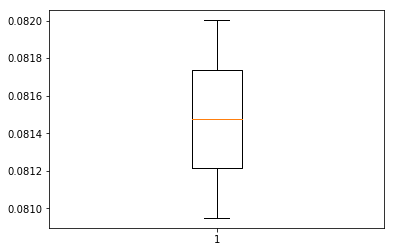

In [39]:
plt.boxplot(mses)
plt.savefig("mse_1_step_boxplot.png", dpi=200)

In [40]:
# MSE Over time
n_steps = len(full_losses[0])
for i in range(n_steps):
    mse_i = [full_losses[x][i] for x in range(len(PATHS))]
    mean_mse = np.mean(mse_i)
    std_mse = np.std(mse_i)
    print(f"Step {i + 1}: {format(mean_mse, precision=2)}±{format(std_mse, precision=1)}")

Step 1: 8.09e-02±3.3e-04
Step 2: 1.51e-01±2.1e-03
Step 3: 1.97e-01±3.2e-03
Step 4: 2.23e-01±4.5e-03
Step 5: 2.38e-01±7.0e-03
Step 6: 2.53e-01±8.5e-03
Step 7: 2.62e-01±8.7e-03
Step 8: 2.72e-01±9.6e-03
Step 9: 2.74e-01±1.1e-02
Step 10: 2.78e-01±1.2e-02
Step 11: 2.85e-01±1.2e-02
Step 12: 2.95e-01±1.3e-02
Step 13: 3.05e-01±1.4e-02
Step 14: 3.06e-01±1.4e-02
Step 15: 3.07e-01±1.4e-02
Step 16: 3.16e-01±1.4e-02
Step 17: 3.25e-01±1.6e-02
Step 18: 3.27e-01±1.6e-02
Step 19: 3.39e-01±1.7e-02
Step 20: 3.44e-01±1.8e-02


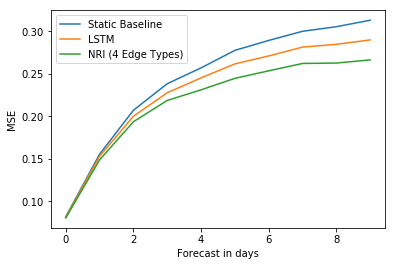

In [58]:
# Plot MSE over time
len_timesteps = 10

plt.ylabel("MSE")
plt.xlabel("Forecast in days")
plt.plot(np.arange(len_timesteps), baselines[0][:len_timesteps], label="Static Baseline")
plt.plot(np.arange(len_timesteps), full_losses[0][:len_timesteps], label="LSTM")
plt.plot(np.arange(len_timesteps), full_losses[1][:len_timesteps], label="NRI (4 Edge Types)")
# TODO: Do the same for the other models/ baseline, we want to consider 

plt.legend()
plt.savefig("mse_timesteps.png", dpi=200)

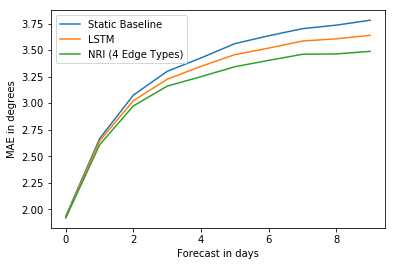

In [59]:
# Recreate deviation in degrees
# y = (x - mean) / std -> y * std = x - mean
# mse: (ground_truth - predictions)**2 -> sqrt(mse) * std is average error in degrees

len_timesteps = 10

plt.ylabel("MAE in degrees")
plt.xlabel("Forecast in days")
plt.plot(np.arange(len_timesteps), np.sqrt(baselines[0][:len_timesteps]) * std, label="Static Baseline")
plt.plot(np.arange(len_timesteps), np.sqrt(full_losses[0][:len_timesteps]) * std, label="LSTM")
plt.plot(np.arange(len_timesteps),  np.sqrt(full_losses[1][:len_timesteps]) * std, label="NRI (4 Edge Types)")
# TODO: Do the same for the other models/ baseline, we want to consider 

plt.legend()
plt.savefig("mse_timesteps.png", dpi=200)